# Core Depletion

In [1]:
import openmc 
import openmc.deplete

%matplotlib inline
import numpy as np

## Pincell Model

In [2]:
# materials
fuel = openmc.Material(name="uo2")
fuel.add_element("U",1.0, percent_type="ao",enrichment=5.0)
fuel.add_element("O",2.0)
fuel.set_density("g/cc",10.45)

clad = openmc.Material(name="clad")
clad.add_element("Zr",0.981858,percent_type="wo");
clad.add_element("O",0.001196,percent_type="wo");
clad.add_element("Cr",9.97e-4,percent_type="wo");
clad.add_element("Fe",1.994e-3,percent_type="wo");
clad.add_element("Sn",1.3955e-2,percent_type="wo");
clad.set_density("g/cc",6.56)

gas = openmc.Material(name="gas")
gas.add_element("He",1.0,percent_type="ao");
gas.set_density("g/cc",1.47e-2);

blanket = openmc.Material(name="blanket")
blanket.add_element("U",1.0,percent_type="ao");
blanket.set_density("g/cc",18.95);

water = openmc.Material(name="water");
water.add_element("O",1);
water.add_element("H",2);
water.set_density("g/cc",0.712);
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,gas,blanket,water]);


In [3]:
# Geometry - surfaces

h_fuel = 100. # cm
h_core = 150. # cm
r_core = 60. # cm
P_D = 1.3     # pitch/diameter ratio
N_assy = 9; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch

N_core = 7; # number of assemblies per dimension in the core
c_pitch = N_core*a_pitch


c_fo = openmc.ZCylinder(r=r_fo);
c_ci = openmc.ZCylinder(r=r_ci);
c_co = openmc.ZCylinder(r=r_co);
c_t = openmc.ZPlane(z0=h_fuel/2.);
c_b = openmc.ZPlane(z0=-h_fuel/2.);

#pin_f = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
#                                             -pitch/2.,pitch/2.,
#                                             -h_fuel/2.,h_fuel/2.);

assy_cell = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_fuel/2.,h_fuel/2.);
all_assy_cell = openmc.model.RectangularParallelepiped(-c_pitch/2.,c_pitch/2.,
                                                  -c_pitch/2.,c_pitch/2.,
                                                  -h_fuel/2.,h_fuel/2.);

core_cell = openmc.model.RightCircularCylinder([0.,0.,-h_core/2.],
                                              h_core,r_core,
                                              boundary_type = 'vacuum');


 # cells and universe for fuel pin cell
    
fuel_cell = openmc.Cell();
fuel_cell.fill = fuel;
fuel_cell.region = -c_t & +c_b & -c_fo;

gap_cell = openmc.Cell();
gap_cell.fill = gas;
gap_cell.region = +c_fo & -c_ci & +c_b & -c_t;

clad_cell = openmc.Cell();
clad_cell.fill = clad;
clad_cell.region = +c_ci & -c_co & +c_b & -c_t;

water_by_fuel = openmc.Cell();
water_by_fuel.fill = water;
water_by_fuel.region = +c_co & +c_b & -c_t;


water_cell = openmc.Cell();
water_cell.region = -core_cell 
water_cell.fill = water;

all_water = openmc.Universe();
all_water.add_cell(water_cell);

fpc = openmc.Universe(); # fuel pincell
fpc.add_cells([fuel_cell,gap_cell,clad_cell,water_by_fuel]);

# seed lattice
SL = openmc.RectLattice();
SL.center = (0.,0.);
SL.dimension = [N_assy,N_assy];
SL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
SL.pitch = [pitch,pitch]
SL.universes = [
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc],
    [fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc,fpc]
]
SL.outer = all_water;

S = openmc.Universe();
seed_cell = openmc.Cell();
seed_cell.fill = SL;
seed_cell.region = -assy_cell;
S.add_cell(seed_cell);


# cells and universe for blanket cell
blanket_cell = openmc.Cell();
blanket_cell.fill = blanket
blanket_cell.region = -c_fo & +c_b & -c_t;


bpc = openmc.Universe(); # blanket pincell
bpc.add_cells([blanket_cell,gap_cell,clad_cell,
              water_by_fuel]);

# blanket lattice
BL = openmc.RectLattice();
BL.dimension = [N_assy,N_assy];
BL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
BL.pitch = [pitch,pitch];
BL.universes = [
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc],
    [bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc,bpc]    
]
BL.outer = all_water;

B = openmc.Universe();
blanket_cell = openmc.Cell();
blanket_cell.region = -assy_cell;
blanket_cell.fill = BL;
B.add_cell(blanket_cell);

# water lattice
WL = openmc.RectLattice();
WL.dimension = [N_assy,N_assy];
WL.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
WL.pitch = [pitch,pitch];
WL.universes = [
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9,
    [all_water]*9    
]
WL.outer = all_water;

W = openmc.Universe();
water_cell = openmc.Cell();
water_cell.region = -assy_cell;
water_cell.fill = WL;
W.add_cell(water_cell);

# core lattice
CL = openmc.RectLattice();
CL.dimension = [N_core,N_core];
CL.lower_left = [-c_pitch/2.,-c_pitch/2.]
CL.pitch = [a_pitch,a_pitch];
CL.universes = [
    [W,B,B,B,B,B,W],
    [B,B,S,S,S,B,B],
    [B,S,S,S,S,S,B],
    [B,S,S,S,S,S,B],
    [B,S,S,S,S,S,B],
    [B,B,S,S,S,B,B],
    [W,B,B,B,B,B,W]  
    
]
CL.outer = all_water;

assy = openmc.Cell();
assy.region = -all_assy_cell;
assy.fill = CL;

core_ref = openmc.Cell();
core_ref.region = +all_assy_cell & -core_cell
core_ref.fill = water;

root_univ = openmc.Universe();
root_univ.add_cells([assy,core_ref]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

materials.export_to_xml();
geometry.export_to_xml();


In [4]:
colors = {}
colors[water]='blue';
colors[fuel]='yellow';
colors[clad]='gray';
colors[gas]='pink';
colors[blanket]='green';

#fpc.plot(width=(1,1),color_by='material',colors=colors)

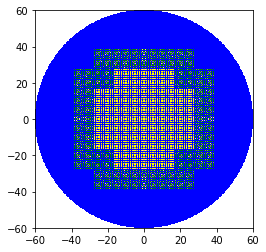

In [5]:
root_univ.plot(width=(120,120),pixels=(800,800),color_by='material',colors=colors)

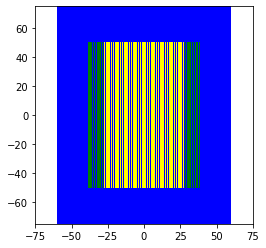

In [6]:
root_univ.plot(width=(150,150),pixels=(800,800),
               basis='yz',
               color_by='material',colors=colors)

I *think* the model is now created correctly.  Just to see how things go, I will add some simple criticality checks.

In [7]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-c_pitch/2.,-c_pitch/2.,-h_fuel/2.),
                      upper_right=(c_pitch/2.,c_pitch/2.,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

In [8]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached. ERROR: Maximum number of lost particles has been reached. ERROR: Maximum number of lost particles has been reached.